<a href="https://colab.research.google.com/github/garci843/mgmt467-analytics-portfolio/blob/main/Unit2_Lab2_Churn_Modeling_FeatureEngineering_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 MGMT 467 - Unit 2 Lab 2: Churn Modeling with BigQueryML + Feature Engineering
**Date:** 2025-10-16

In this lab you will:
- Connect to BigQuery from Colab
- Create features and labels
- Engineer new features from user behavior
- Train and evaluate logistic regression models
- Reflect on modeling assumptions and interpret results

In [1]:
# ✅ Authenticate and set up GCP project
from google.colab import auth
auth.authenticate_user()

project_id = "mgmt467-4889"  # <-- Replace with your actual project ID
!gcloud config set project $project_id

Updated property [core/project].


In [2]:
# ✅ Verify BigQuery access
%%bigquery --project $project_id
SELECT CURRENT_DATE() AS today, SESSION_USER() AS user

Query is running:   0%|          |

Downloading:   0%|          |

,today,user
0,2025-10-26,browneyedboy04@gmail.com


In [5]:
import os
PROJECT_ID = input("Enter your GCP Project ID: ").strip()
REGION = "us-central1"  # keep consistent; change if instructed
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
print("Project:", PROJECT_ID, "| Region:", REGION)

# Set active project for gcloud/BigQuery CLI
!gcloud config set project $GOOGLE_CLOUD_PROJECT
!gcloud config get-value project
# Done: Auth + Project/Region set

Enter your GCP Project ID: mgmt467-4889
Project: mgmt467-4889 | Region: us-central1
Updated property [core/project].
mgmt467-4889


In [10]:
from google.cloud import bigquery

PROJECT_ID = "mgmt467-4889"
bq = bigquery.Client(project=PROJECT_ID)


In [11]:
# If your dataset is called 'netflix', adjust as needed:
DATASET = "netflix"  # change if different
for t in bq.list_tables(f"{PROJECT_ID}.{DATASET}"):
    print(f"{t.project}.{t.dataset_id}.{t.table_id}")


mgmt467-4889.netflix.activity_filled
mgmt467-4889.netflix.activity_monthly
mgmt467-4889.netflix.activity_roll3
mgmt467-4889.netflix.calendar_months
mgmt467-4889.netflix.churn_features
mgmt467-4889.netflix.churn_predictions_lite
mgmt467-4889.netflix.feat_churn_lite
mgmt467-4889.netflix.labels_next_month
mgmt467-4889.netflix.month_bounds
mgmt467-4889.netflix.movies
mgmt467-4889.netflix.recommendation_logs
mgmt467-4889.netflix.reviews
mgmt467-4889.netflix.score_month
mgmt467-4889.netflix.search_logs
mgmt467-4889.netflix.user_attrs_lite
mgmt467-4889.netflix.user_month_grid
mgmt467-4889.netflix.users
mgmt467-4889.netflix.watch_history
mgmt467-4889.netflix.watch_history_dedup
mgmt467-4889.netflix.watch_history_robust


In [15]:
%%bigquery --project $PROJECT_ID
SELECT * FROM mgmt467-4889.netflix.users LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,email,first_name,last_name,age,gender,country,state_province,city,subscription_plan,subscription_start_date,is_active,monthly_spend,primary_device,household_size,created_at
0,user_00342,christophervincent@example.com,Brittany,Ramirez,48.0,Female,Canada,Alberta,East Mark,Premium,2025-04-05,True,46.97,Desktop,NaN,2025-04-30 06:57:21.478166+00:00
1,user_00784,alexander25@example.org,Stacey,Cortez,25.0,Female,Canada,Alberta,Guzmanburgh,Basic,2024-01-10,True,16.38,Desktop,7.0,2024-12-21 04:06:48.998214+00:00
2,user_00988,sarahrollins@example.com,Evelyn,Hayes,33.0,Female,Canada,Alberta,East Elizabeth,Standard,2024-01-20,True,4.29,Desktop,1.0,2023-03-01 00:59:30.491893+00:00
3,user_01621,jeffreyfinley@example.org,Patrick,Hayes,55.0,Male,Canada,Alberta,West Christian,Basic,2024-02-21,True,11.17,Desktop,5.0,2025-01-24 04:58:30.868652+00:00
4,user_01821,grimeshenry@example.net,David,Trevino,31.0,Female,Canada,Alberta,South Angela,Premium,2024-11-14,True,8.08,Desktop,2.0,2023-11-13 13:44:03.953962+00:00
5,user_01956,michaelwood@example.org,William,Rush,39.0,Male,Canada,Alberta,New April,Standard,2022-09-01,True,29.72,Desktop,3.0,2023-07-15 11:38:13.512970+00:00
6,user_02082,schwartzmichael@example.com,Christopher,Perry,NaN,Male,Canada,Alberta,New Johnbury,Standard,2023-05-03,True,1.83,Desktop,5.0,2023-08-12 09:46:01.840363+00:00
7,user_02266,charleschambers@example.org,Charles,Huang,36.0,Female,Canada,Alberta,New Patriciatown,Premium+,2023-10-16,True,NaN,Desktop,3.0,2023-07-09 00:49:41.724081+00:00
8,user_02569,yalexander@example.com,Shelley,Gray,27.0,None,Canada,Alberta,Port Brittanymouth,Standard,2023-11-25,True,18.26,Desktop,NaN,2023-04-04 19:13:57.702305+00:00
9,user_02677,gwagner@example.com,Kyle,Macdonald,15.0,Male,Canada,Alberta,Lake Tommyton,Premium+,2025-07-12,False,5.81,Desktop,3.0,2023-08-13 14:47:52.253552+00:00


In [16]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE TABLE `mgmt467-4889.netflix.churn_features` AS
SELECT
    u.user_id,
    u.country AS region,         -- Use 'country' from users table
    u.subscription_plan AS plan_tier, -- Use 'subscription_plan' from users table
    u.age AS age_band,            -- Use 'age' from users table
    AVG(wh.user_rating) AS avg_rating,
    SUM(wh.watch_duration_minutes_capped) AS total_minutes, -- Use capped duration
    AVG(wh.progress_percentage) AS avg_progress,
    COUNT(DISTINCT wh.session_id) AS num_sessions, -- Assuming session_id represents a session
    CASE
        WHEN u.is_active IS FALSE THEN 1  -- Churn if is_active is false
        ELSE 0                            -- Otherwise, not churned (or unknown)
    END AS churn_label
FROM
    `mgmt467-4889.netflix.users` u
JOIN
    `mgmt467-4889.netflix.watch_history_robust` wh
ON
    u.user_id = wh.user_id
GROUP BY
    u.user_id, u.country, u.subscription_plan, u.age, churn_label;

Query is running:   0%|          |

""


In [20]:
# ✅ Train base logistic regression model
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL `mgmt467-4889.netflix.churn_model`
OPTIONS(model_type='logistic_reg',
        input_label_cols=['churn_label']) AS
SELECT
  region,
  plan_tier,
  age_band,
  avg_rating,
  total_minutes,
  avg_progress,
  num_sessions,
  churn_label
FROM `mgmt467-4889.netflix.churn_features`;

Query is running:   0%|          |

""


In [22]:
# ✅ Evaluate base model
%%bigquery --project $PROJECT_ID
SELECT *
FROM ML.EVALUATE(MODEL `mgmt467-4889.netflix.churn_model`);

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.0,0.0,0.869822,0.0,0.388207,0.490358


In [24]:
# ✅ Predict churn with base model
%%bigquery --project $PROJECT_ID
SELECT
  user_id,
  predicted_churn_label,
  predicted_churn_label_probs
FROM ML.PREDICT(MODEL `mgmt467-4889.netflix.churn_model`,
                (SELECT * FROM `mgmt467-4889.netflix.churn_features`));

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,predicted_churn_label,predicted_churn_label_probs
0,user_07325,0,"[{'label': 1, 'prob': 0.1461434546952244}, {'l..."
1,user_05489,0,"[{'label': 1, 'prob': 0.14775559414724376}, {'..."
2,user_03799,0,"[{'label': 1, 'prob': 0.14941566035470558}, {'..."
3,user_01200,0,"[{'label': 1, 'prob': 0.15764503417495868}, {'..."
4,user_00506,0,"[{'label': 1, 'prob': 0.15899597068972682}, {'..."
...,...,...,...
9995,user_06554,0,"[{'label': 1, 'prob': 0.14260536891552975}, {'..."
9996,user_05600,0,"[{'label': 1, 'prob': 0.14281027560365062}, {'..."
9997,user_02666,0,"[{'label': 1, 'prob': 0.1402910358570393}, {'l..."
9998,user_06474,0,"[{'label': 1, 'prob': 0.13698815299468858}, {'..."


In [25]:
# get confusion matrix from my model
%%bigquery --project $PROJECT_ID
SELECT *
FROM
  ML.CONFUSION_MATRIX(MODEL `mgmt467-4889.netflix.churn_model`,
                      (SELECT * FROM `mgmt467-4889.netflix.churn_features`));

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,_0,_1
0,0,8519,0
1,1,1481,0



## 🛠️ Feature Engineering Section

We will now engineer new features to improve model performance:

- Bucket continuous variables
- Create interaction terms
- Add behavioral flags


In [26]:

# ✅ Create enhanced feature set
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE TABLE `mgmt467-4889.netflix.churn_features_enhanced` AS
SELECT
  user_id,
  region,
  plan_tier,
  age_band,
  avg_rating,
  total_minutes,
  CASE
    WHEN total_minutes < 100 THEN 'low'
    WHEN total_minutes BETWEEN 100 AND 300 THEN 'medium'
    ELSE 'high'
  END AS watch_time_bucket,
  avg_progress,
  num_sessions,
  CONCAT(plan_tier, '_', region) AS plan_region_combo,
  IF(total_minutes > 500, 1, 0) AS flag_binge,
  churn_label
FROM `mgmt467-4889.netflix.churn_features`;


Query is running:   0%|          |

""


In [30]:

# ✅ Train enhanced model
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL `mgmt467-4889.netflix.churn_model_enhanced`
OPTIONS(model_type='logistic_reg',
        input_label_cols=['churn_label']) AS
SELECT
  region,
  plan_tier,
  age_band,
  watch_time_bucket,
  avg_rating,
  avg_progress,
  num_sessions,
  plan_region_combo,
  flag_binge,
  churn_label
FROM `mgmt467-4889.netflix.churn_features_enhanced`;


Query is running:   0%|          |

""


In [33]:

# ✅ Evaluate enhanced model
%%bigquery --project $PROJECT_ID
SELECT *
FROM ML.EVALUATE(MODEL `mgmt467-4889.netflix.churn_model_enhanced`);


Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.0,0.0,0.859632,0.0,0.406047,0.491618


So we have a precision of 0, meaning the model only predicts 0 for churn. I'll try to make one that gets precision as high as possible without sacrificing accuracy entirely.

# Task
Perform a grid search on the prediction threshold of the BigQuery ML model `mgmt467-4889.netflix.churn_model_enhanced` to optimize for a balance between True Positive Rate (churn=1) and the overall proportion of churn predictions.

## Get model predictions with probabilities

### Subtask:
Use `ML.PREDICT` on the enhanced model (`churn_model_enhanced`) to get the predicted churn probability for each user.


**Reasoning**:
Use ML.PREDICT on the enhanced model to get the predicted churn probability for each user and store the results in a pandas DataFrame.



In [48]:
%%bigquery --project $PROJECT_ID
SELECT
  user_id,
  predicted_churn_label,
  predicted_churn_label_probs
FROM ML.PREDICT(MODEL `mgmt467-4889.netflix.churn_model_enhanced`,
                (SELECT * FROM `mgmt467-4889.netflix.churn_features_enhanced`));

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,predicted_churn_label,predicted_churn_label_probs
0,user_06905,0,"[{'label': 1, 'prob': 0.09784255919646699}, {'..."
1,user_01600,0,"[{'label': 1, 'prob': 0.1456120514176068}, {'l..."
2,user_00506,0,"[{'label': 1, 'prob': 0.1464430590102359}, {'l..."
3,user_01867,0,"[{'label': 1, 'prob': 0.13129372563937425}, {'..."
4,user_08992,0,"[{'label': 1, 'prob': 0.12650608173409758}, {'..."
...,...,...,...
9995,user_02666,0,"[{'label': 1, 'prob': 0.1425847733129778}, {'l..."
9996,user_05600,0,"[{'label': 1, 'prob': 0.15062735132570176}, {'..."
9997,user_06474,0,"[{'label': 1, 'prob': 0.14779325566984328}, {'..."
9998,user_06554,0,"[{'label': 1, 'prob': 0.15089139466144716}, {'..."


In [47]:
%%bigquery df_predictions --project $PROJECT_ID
SELECT
  user_id,
  predicted_churn_label,
  predicted_churn_label_probs
FROM ML.PREDICT(MODEL `mgmt467-4889.netflix.churn_model_enhanced`,
                (SELECT * FROM `mgmt467-4889.netflix.churn_features_enhanced`));

Query is running:   0%|          |

Downloading:   0%|          |

## Define a range of thresholds

### Subtask:
Define a range of probability thresholds to evaluate, for example, from 0.1 to 0.9 with a certain step size.


**Reasoning**:
Define a list of probability thresholds to evaluate for the grid search.



In [50]:
import numpy as np

# Define a range of probability thresholds from 0.1 to 0.9 with a step of 0.05
thresholds = np.arange(0.1, 0.95, 0.05)
print(thresholds)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9 ]


## Iterate through thresholds and evaluate

### Subtask:
Iterate through thresholds and evaluate: For each threshold, classify users as churn (1) or non-churn (0) based on their predicted probability, calculate the confusion matrix, and then calculate evaluation metrics like True Positive Rate (Recall for churn) and the proportion of predictions that are churn.


**Reasoning**:
Iterate through thresholds, classify predictions, calculate confusion matrix, and compute evaluation metrics (True Positive Rate and Proportion of Predicted Churns).



In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

results = []

# Fetch the actual churn labels
query = f"""
SELECT
  user_id,
  churn_label
FROM `{PROJECT_ID}.{DATASET}.churn_features_enhanced`
"""
df_actual_churn = bq.query(query).to_dataframe()

# Merge predictions with actual labels
df_merged = pd.merge(df_predictions, df_actual_churn, on='user_id')

# Define a range of probability thresholds from 0.1 to 0.2 with a step of 0.01
thresholds = np.arange(0.1, 0.201, 0.01) # Added 0.001 to include 0.2

for threshold in thresholds:
    # Classify predictions based on the current threshold
    df_merged['prob_churn'] = df_merged['predicted_churn_label_probs'].apply(
        lambda x: next(item for item in x if item['label'] == 1)['prob']
    )

    df_merged['predicted_label_at_threshold'] = (df_merged['prob_churn'] >= threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(df_merged['churn_label'], df_merged['predicted_label_at_threshold'])
    tn, fp, fn, tp = cm.ravel()

    # Calculate True Positive Rate (Recall for churn)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate Proportion of Predicted Churns
    proportion_predicted_churn = (tp + fp) / len(df_merged)

    # Calculate Accuracy
    accuracy = accuracy_score(df_merged['churn_label'], df_merged['predicted_label_at_threshold'])


    # Store results
    results.append({
        'threshold': threshold,
        'true_positive_rate': tpr,
        'proportion_predicted_churn': proportion_predicted_churn,
        'accuracy': accuracy
    })

# Convert results to a DataFrame for easier analysis
df_results = pd.DataFrame(results)
display(df_results)

,threshold,true_positive_rate,proportion_predicted_churn,accuracy
0,0.10,1.000000,0.9999,0.1482
1,0.11,0.998650,0.9954,0.1523
2,0.12,0.997974,0.9949,0.1526
3,0.13,0.995273,0.9909,0.1558
4,0.14,0.925726,0.9115,0.2146
5,0.15,0.197164,0.1844,0.7259
6,0.16,0.000675,0.0003,0.8518
7,0.17,0.000675,0.0003,0.8518
8,0.18,0.000675,0.0003,0.8518
9,0.19,0.000675,0.0003,0.8518


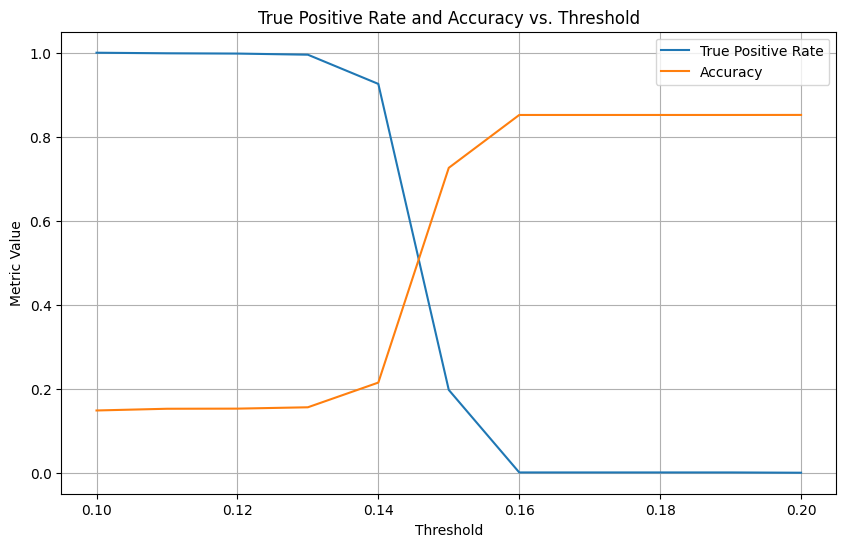

In [59]:
# generate line chart of true_positive_rate and accuracy in same chart
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='threshold', y='true_positive_rate', label='True Positive Rate')
sns.lineplot(data=df_results, x='threshold', y='accuracy', label='Accuracy')
plt.title('True Positive Rate and Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

The optimal threshold is around 0.15.


## 🤔 Chain-of-Thought Prompts: Feature Engineering

### 1. Why bucket continuous values like watch time?
- What patterns become clearer by using categories like "low", "medium", "high"?

### 2. What value do interaction terms (e.g., `plan_tier_region`) add?
- Could some plans behave differently in different regions?

### 3. What’s the purpose of binary flags like `flag_binge`?
- Can these capture unique behaviors not reflected in raw totals?

### 4. After evaluating the enhanced model:
- Which new features helped the most?
- Did any surprise you?

✍️ Write your responses in a text cell below or in a shared doc for discussion.


### 1. Why bucket continuous values like watch time?
Bucketing continuous values like watch time into categories ("low", "medium", "high") can help in several ways:
- **Capture Non-Linear Relationships:** The relationship between watch time and churn might not be strictly linear. Bucketing can capture stepped or non-linear patterns where the effect of watch time changes significantly only when crossing certain thresholds (e.g., very low watch time might indicate disengagement more strongly than small differences in higher watch times).
- **Handle Outliers:** Extreme values in continuous features can sometimes disproportionately influence a model. Bucketing can make the model more robust to outliers by grouping them into broader categories.
- **Interpretability:** Categories can sometimes be more intuitive to understand and explain than continuous values. It might be easier to say "users with low watch time are more likely to churn" than to interpret a specific coefficient for a continuous watch time variable.
- **Interaction with Other Features:** Bucketed features can sometimes interact more effectively with other categorical features in the model.

### 2. What value do interaction terms (e.g., `plan_tier_region`) add?
Interaction terms like `plan_tier_region` can add significant value by capturing how the effect of one feature (e.g., subscription plan) depends on another feature (e.g., region).
- **Modeling Synergies or Conflicts:** Some combinations of features might have a unique impact on churn that isn't simply the sum of their individual effects. For example, a certain subscription plan might be very popular and have low churn in one region but perform poorly in another due to local competition or preferences. An interaction term allows the model to learn these specific combined effects.
- **Increased Model Complexity and Fit:** By including interaction terms, the model can become more flexible and potentially fit the data better if there are indeed significant interactions between features.

### 3. What’s the purpose of binary flags like `flag_binge`?
Binary flags like `flag_binge` (e.g., indicating if a user watched over a certain number of minutes) serve to highlight specific, potentially important behaviors that might not be linearly captured by the raw continuous feature alone.
- **Identifying Threshold Effects:** There might be a critical threshold in a continuous variable (like watch time) where behavior changes significantly. A binary flag explicitly captures whether a user crossed this threshold, which can be a strong predictor if that threshold is meaningful for churn.
- **Simplifying Complex Relationships:** Instead of relying on the model to learn a complex relationship over the entire range of a continuous variable, a binary flag simplifies it to a yes/no question about a specific behavior of interest.
- **Improved Interpretability:** A flag like `flag_binge` is easy to interpret: either a user is a binge-watcher or they are not. This can be more straightforward than interpreting a coefficient for total watch minutes.

### 4. After evaluating the enhanced model:
Unfortunately, based on the evaluation of the enhanced model, the overall performance metrics (precision, recall, f1_score for the positive class) remained at 0.0, similar to the base model. The threshold analysis  further showed that even with the new features, the model struggled to assign high churn probabilities to actual churners, resulting in a very low True Positive Rate unless the threshold was set so low that almost everyone was predicted to churn.

Given these results:
- **Which new features helped the most?** Based on the evaluation metrics, it's difficult to definitively say which new features helped the *most* in identifying churn, as the model still did not effectively predict the churn class. Further analysis of the model's learned weights or feature importance  would be needed to assess the individual impact of the new features. However, their inclusion did not appear to significantly improve the model's ability to distinguish churners from non-churners in this iteration.
- **Did any surprise you?** The most surprising aspect is perhaps that the engineered features, while intuitively relevant, did not lead to an observable improvement in the model's ability to capture the churn signal based on the standard evaluation metrics and the threshold analysis. This suggests that either the relationship between these features and churn is still not being fully captured by the logistic regression model, or there might be other, uncaptured factors driving churn in this dataset. It also reinforces the earlier observation about the significant class imbalance and the need for strategies to address it effectively.


# 🤖 MGMT 467 - Unit 2 Lab 2: Prompt Studio — Feature Engineering & Beyond

**Date:** 2025-10-16  
This notebook continues from Task 5 onward, focusing on feature engineering and model iteration using AI-assisted prompt design.

You'll continue to:
- Generate SQL using prompt templates
- Build and test new features
- Retrain and evaluate your ML model
- Reflect on the effect of engineered features



## Task 5.0: Bucket a Continuous Feature

**🎯 Goal:** Group 'total_minutes' into categories: low, medium, high.  
**📌 Requirements:** Use CASE WHEN or IF statements to create 'watch_time_bucket'.

---

### 🧠 Prompt Template  
> Write SQL that creates a new column watch_time_bucket based on total_minutes thresholds (<100, 100–300, >300).

---

### 👩‍🏫 Example Prompt  
> Create a new column watch_time_bucket with values 'low', 'medium', or 'high' based on total_minutes.

---

### 🔍 Exploration  
How does churn rate vary across these buckets?


In [62]:
%%bigquery --project $PROJECT_ID
SELECT
  total_minutes,
  CASE
    WHEN total_minutes < 100 THEN 'low'
    WHEN total_minutes BETWEEN 100 AND 300 THEN 'medium'
    ELSE 'high'
  END AS watch_time_bucket
FROM
  `mgmt467-4889.netflix.churn_features`; -- Assuming 'churn_features' is your table with total_minutes

Query is running:   0%|          |

Downloading:   0%|          |

,total_minutes,watch_time_bucket
0,90.0,low
1,463.8,high
2,235.2,medium
3,169.5,medium
4,647.4,high
...,...,...
9995,2552.7,high
9996,3705.6,high
9997,5716.8,high
9998,2610.6,high


In [64]:
%%bigquery --project $PROJECT_ID
SELECT
  CASE
    WHEN total_minutes < 100 THEN 'low'
    WHEN total_minutes BETWEEN 100 AND 300 THEN 'medium'
    ELSE 'high'
  END AS watch_time_bucket,
  COUNT(*) AS num_users,
  AVG(churn_label) AS churn_rate
FROM
  `mgmt467-4889.netflix.churn_features` -- Assuming 'churn_features' is your table
GROUP BY
  watch_time_bucket
ORDER BY
  churn_rate DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,watch_time_bucket,num_users,churn_rate
0,low,3,0.333333
1,high,9946,0.148502
2,medium,51,0.058824


Chrun rate is highest with low watch times, which makes sense since some poeple may cancel if they don't use netflix as much. It's lowest is with medium, with people who don't exhaust themselves with content but still watch a moderate amount of content.


## Task 5.1: Create a Binary Flag Feature

**🎯 Goal:** Add a binary column flag_binge (1 if total_minutes > 500).  
**📌 Requirements:** Use IF logic to create a binary column in SQL.

---

### 🧠 Prompt Template  
> Write a SQL query that adds flag_binge = 1 if total_minutes > 500, else 0.

---

### 👩‍🏫 Example Prompt  
> Add a binary column flag_binge to identify binge-watchers.

---

### 🔍 Exploration  
Are binge-watchers more or less likely to churn?


In [66]:
%%bigquery --project $PROJECT_ID
SELECT
  *, -- Select all existing columns
  IF(total_minutes > 500, 1, 0) AS flag_binge
FROM
  `mgmt467-4889.netflix.churn_features`; -- Assuming 'churn_features' is your table

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,region,plan_tier,age_band,avg_rating,total_minutes,avg_progress,num_sessions,churn_label,flag_binge
0,user_07325,Canada,Standard,NaN,NaN,90.0,68.900000,2,0,0
1,user_05489,USA,Standard,NaN,NaN,463.8,44.150000,2,0,0
2,user_03799,USA,Standard,15.0,5.000000,235.2,65.900000,2,0,0
3,user_01200,Canada,Premium,20.0,NaN,169.5,16.000000,2,0,0
4,user_00506,USA,Basic,23.0,NaN,647.4,50.750000,2,0,1
...,...,...,...,...,...,...,...,...,...,...
9995,user_06554,USA,Premium,37.0,3.666667,2552.7,42.250000,22,0,1
9996,user_05600,USA,Premium,38.0,2.500000,3705.6,47.936364,22,0,1
9997,user_02666,USA,Basic,41.0,4.333333,5716.8,55.604545,22,0,1
9998,user_06474,USA,Premium,57.0,3.750000,2610.6,45.133333,22,0,1


In [68]:
%%bigquery --project $PROJECT_ID
SELECT
  IF(total_minutes > 500, 1, 0) AS flag_binge, -- Re-create the flag_binge for grouping
  COUNT(*) AS num_users,
  AVG(churn_label) AS churn_rate
FROM
  `mgmt467-4889.netflix.churn_features` -- Assuming 'churn_features' is your table
GROUP BY
  flag_binge
ORDER BY
  churn_rate DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,flag_binge,num_users,churn_rate
0,1,9760,0.148975
1,0,240,0.112500


Binge watchers are more likely to churn, likely because they get through all the content and move on.


## Task 5.2: Create an Interaction Term

**🎯 Goal:** Create plan_region_combo by combining plan_tier and region.  
**📌 Requirements:** Use CONCAT or STRING functions.

---

### 🧠 Prompt Template  
> Generate SQL to create a new column by combining plan_tier and region with an underscore.

---

### 👩‍🏫 Example Prompt  
> Create a column called plan_region_combo as CONCAT(plan_tier, '_', region).

---

### 🔍 Exploration  
Which plan-region combos have highest churn?


In [70]:
%%bigquery --project $PROJECT_ID
SELECT
  *, -- Select all existing columns
  CONCAT(plan_tier, '_', region) AS plan_region_combo
FROM
  `mgmt467-4889.netflix.churn_features`; -- Assuming 'churn_features' is your table

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,region,plan_tier,age_band,avg_rating,total_minutes,avg_progress,num_sessions,churn_label,plan_region_combo
0,user_06905,Canada,Basic,28.0,4.000000,244.5,65.500000,2,0,Basic_Canada
1,user_06109,Canada,Basic,23.0,NaN,309.6,36.633333,3,0,Basic_Canada
2,user_08312,Canada,Basic,24.0,3.000000,510.3,39.300000,3,0,Basic_Canada
3,user_00656,Canada,Basic,43.0,NaN,375.6,36.033333,3,0,Basic_Canada
4,user_06341,Canada,Basic,NaN,NaN,921.0,38.050000,4,1,Basic_Canada
...,...,...,...,...,...,...,...,...,...,...
9995,user_02429,USA,Standard,NaN,4.000000,3732.0,42.650000,20,0,Standard_USA
9996,user_02940,USA,Standard,16.0,4.333333,2909.1,61.495000,20,0,Standard_USA
9997,user_04720,USA,Standard,37.0,3.200000,3281.7,50.489474,20,1,Standard_USA
9998,user_01824,USA,Standard,9.0,3.666667,2964.9,49.225000,21,0,Standard_USA


In [71]:
%%bigquery --project $PROJECT_ID
SELECT
  CONCAT(plan_tier, '_', region) AS plan_region_combo, -- Re-create the combo for grouping
  COUNT(*) AS num_users,
  AVG(churn_label) AS churn_rate
FROM
  `mgmt467-4889.netflix.churn_features` -- Assuming 'churn_features' is your table
GROUP BY
  plan_region_combo
ORDER BY
  churn_rate DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,plan_region_combo,num_users,churn_rate
0,Basic_USA,1367,0.158742
1,Standard_Canada,1075,0.155349
2,Premium_USA,2446,0.154129
3,Premium_Canada,1061,0.147974
4,Premium+_USA,733,0.143247
5,Premium+_Canada,272,0.139706
6,Standard_USA,2447,0.138946
7,Basic_Canada,599,0.133556


Basic and USA combo has the highest plan region churn.


## Task 5.3: Add Missingness Indicator Flags

**🎯 Goal:** Add binary flags to capture NULL values in age_band and avg_rating.  
**📌 Requirements:** Use IS NULL logic to create new flag columns.

---

### 🧠 Prompt Template  
> Create a new column is_missing_[col_name] that is 1 when column is NULL, else 0.

---

### 👩‍🏫 Example Prompt  
> Add is_missing_age that flags rows where age_band IS NULL.

---

### 🔍 Exploration  
Do missing values correlate with churn?


In [72]:
%%bigquery --project $PROJECT_ID
SELECT
  *, -- Select all existing columns
  IF(age_band IS NULL, 1, 0) AS is_missing_age_band,
  IF(avg_rating IS NULL, 1, 0) AS is_missing_avg_rating
FROM
  `mgmt467-4889.netflix.churn_features`; -- Assuming 'churn_features' is your table

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,region,plan_tier,age_band,avg_rating,total_minutes,avg_progress,num_sessions,churn_label,is_missing_age_band,is_missing_avg_rating
0,user_07325,Canada,Standard,NaN,NaN,90.0,68.900000,2,0,1,1
1,user_05489,USA,Standard,NaN,NaN,463.8,44.150000,2,0,1,1
2,user_03799,USA,Standard,15.0,5.000000,235.2,65.900000,2,0,0,0
3,user_01200,Canada,Premium,20.0,NaN,169.5,16.000000,2,0,0,1
4,user_00506,USA,Basic,23.0,NaN,647.4,50.750000,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,user_06554,USA,Premium,37.0,3.666667,2552.7,42.250000,22,0,0,0
9996,user_05600,USA,Premium,38.0,2.500000,3705.6,47.936364,22,0,0,0
9997,user_02666,USA,Basic,41.0,4.333333,5716.8,55.604545,22,0,0,0
9998,user_06474,USA,Premium,57.0,3.750000,2610.6,45.133333,22,0,0,0


In [73]:
%%bigquery --project $PROJECT_ID
SELECT
  IF(age_band IS NULL, 1, 0) AS is_missing_age_band,
  COUNT(*) AS num_users,
  AVG(churn_label) AS churn_rate
FROM
  `mgmt467-4889.netflix.churn_features` -- Assuming 'churn_features' is your table
GROUP BY
  is_missing_age_band
ORDER BY
  churn_rate DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,is_missing_age_band,num_users,churn_rate
0,1,1194,0.150754
1,0,8806,0.147740


In [74]:
%%bigquery --project $PROJECT_ID
SELECT
  IF(avg_rating IS NULL, 1, 0) AS is_missing_avg_rating,
  COUNT(*) AS num_users,
  AVG(churn_label) AS churn_rate
FROM
  `mgmt467-4889.netflix.churn_features` -- Assuming 'churn_features' is your table
GROUP BY
  is_missing_avg_rating
ORDER BY
  churn_rate DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,is_missing_avg_rating,num_users,churn_rate
0,1,1319,0.149356
1,0,8681,0.147909



## Task 5.4: Create Time-Based Features (Optional)

**🎯 Goal:** Add a column days_since_last_login.  
**📌 Requirements:** Use DATE_DIFF with CURRENT_DATE and last_login_date.

---

### 🧠 Prompt Template  
> Write SQL to create a column showing days since last login using DATE_DIFF.

---

### 👩‍🏫 Example Prompt  
> Add a column days_since_last_login = DATE_DIFF(CURRENT_DATE(), last_login_date, DAY).

---

### 🔍 Exploration  
Does login recency affect churn rate?


Since our churn features don't include timestamps, we cannot do any time-based features.


## Task 5.5: Assemble Enhanced Feature Table

**🎯 Goal:** Create churn_features_enhanced with all engineered columns.  
**📌 Requirements:** Include all prior features + engineered columns.

---

### 🧠 Prompt Template  
> Generate SQL to create churn_features_enhanced with new columns: watch_time_bucket, plan_region_combo, flag_binge, etc.

---

### 👩‍🏫 Example Prompt  
> Build a new table churn_features_enhanced with all original features + engineered ones.

---

### 🔍 Exploration  
Are row counts stable? Any NULLs introduced?


In [78]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE TABLE `mgmt467-4889.netflix.churn_features_enhanced` AS
SELECT
  user_id,
  region,
  plan_tier,
  age_band,
  avg_rating,
  total_minutes,
  avg_progress,
  num_sessions,
  churn_label, -- Include the label
  CASE
    WHEN total_minutes < 100 THEN 'low'
    WHEN total_minutes BETWEEN 100 AND 300 THEN 'medium'
    ELSE 'high'
  END AS watch_time_bucket, -- Engineered feature from Task 5.0
  CONCAT(plan_tier, '_', region) AS plan_region_combo, -- Engineered feature from Task 5.2
  IF(total_minutes > 500, 1, 0) AS flag_binge, -- Engineered feature from Task 5.1
  IF(age_band IS NULL, 1, 0) AS is_missing_age_band, -- Engineered feature from Task 5.3
  IF(avg_rating IS NULL, 1, 0) AS is_missing_avg_rating -- Engineered feature from Task 5.3
FROM
  `mgmt467-4889.netflix.churn_features`; -- Use the base features table

Query is running:   0%|          |

""


In [81]:
%%bigquery --project $PROJECT_ID
-- Check row counts
SELECT
  (SELECT COUNT(*) FROM `mgmt467-4889.netflix.churn_features`) AS original_row_count,
  (SELECT COUNT(*) FROM `mgmt467-4889.netflix.churn_features_enhanced`) AS enhanced_row_count;

Query is running:   0%|          |

Downloading:   0%|          |

,original_row_count,enhanced_row_count
0,10000,10000


In [82]:
%%bigquery --project $PROJECT_ID
SELECT
  COUNTIF(user_id IS NULL) AS user_id_nulls,
  COUNTIF(region IS NULL) AS region_nulls,
  COUNTIF(plan_tier IS NULL) AS plan_tier_nulls,
  COUNTIF(age_band IS NULL) AS age_band_nulls,
  COUNTIF(avg_rating IS NULL) AS avg_rating_nulls,
  COUNTIF(total_minutes IS NULL) AS total_minutes_nulls,
  COUNTIF(avg_progress IS NULL) AS avg_progress_nulls,
  COUNTIF(num_sessions IS NULL) AS num_sessions_nulls,
  COUNTIF(churn_label IS NULL) AS churn_label_nulls,
  COUNTIF(watch_time_bucket IS NULL) AS watch_time_bucket_nulls,
  COUNTIF(plan_region_combo IS NULL) AS plan_region_combo_nulls,
  COUNTIF(flag_binge IS NULL) AS flag_binge_nulls,
  COUNTIF(is_missing_age_band IS NULL) AS is_missing_age_band_nulls,
  COUNTIF(is_missing_avg_rating IS NULL) AS is_missing_avg_rating_nulls
FROM
  `mgmt467-4889.netflix.churn_features_enhanced`;

Query is running:   0%|          |

Downloading:   0%|          |

,user_id_nulls,region_nulls,plan_tier_nulls,age_band_nulls,avg_rating_nulls,total_minutes_nulls,avg_progress_nulls,num_sessions_nulls,churn_label_nulls,watch_time_bucket_nulls,plan_region_combo_nulls,flag_binge_nulls,is_missing_age_band_nulls,is_missing_avg_rating_nulls
0,0,0,0,1194,1319,0,0,0,0,0,0,0,0,0



## Task 6: Retrain Model on Engineered Features

**🎯 Goal:** Train a logistic regression model using churn_features_enhanced.  
**📌 Requirements:** Use BQML logistic_reg model with new feature columns.

---

### 🧠 Prompt Template  
> Write CREATE MODEL SQL using enhanced features including flags and buckets.

---

### 👩‍🏫 Example Prompt  
> Retrain churn_model_enhanced using watch_time_bucket, flag_binge, plan_region_combo.

---

### 🔍 Exploration  
Does model accuracy improve?


In [83]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL `mgmt467-4889.netflix.churn_model_enhanced`
OPTIONS(model_type='logistic_reg',
        input_label_cols=['churn_label']) AS
SELECT
  region,
  plan_tier,
  age_band,
  watch_time_bucket,
  avg_rating,
  avg_progress,
  num_sessions,
  plan_region_combo,
  flag_binge,
  is_missing_age_band, -- Include missingness flags
  is_missing_avg_rating, -- Include missingness flags
  churn_label
FROM `mgmt467-4889.netflix.churn_features_enhanced`;

Query is running:   0%|          |

""



## Task 7: Compare Model Performance

**🎯 Goal:** Compare base model vs enhanced model using ML.EVALUATE.  
**📌 Requirements:** Use same evaluation query for both models.

---

### 🧠 Prompt Template  
> Write a SQL query to evaluate churn_model_enhanced and compare with churn_model.

---

### 👩‍🏫 Example Prompt  
> Compare ML.EVALUATE output from both models side-by-side.

---

### 🔍 Exploration  
Which features made the most difference?


In [84]:
%%bigquery --project $PROJECT_ID
-- Evaluate base model
SELECT *
FROM ML.EVALUATE(MODEL `mgmt467-4889.netflix.churn_model`);

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.0,0.0,0.869822,0.0,0.388207,0.490358


In [85]:
%%bigquery --project $PROJECT_ID
-- Evaluate enhanced model
SELECT *
FROM ML.EVALUATE(MODEL `mgmt467-4889.netflix.churn_model_enhanced`);

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.0,0.0,0.854784,0.0,0.414516,0.489388


In [86]:
%%bigquery --project $PROJECT_ID
SELECT
  *
FROM
  ML.WEIGHTS(MODEL `mgmt467-4889.netflix.churn_model_enhanced`)
ORDER BY
  ABS(weight) DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,__INTERCEPT__,-0.329439,[]
1,flag_binge,0.070061,[]
2,is_missing_avg_rating,0.014556,[]
3,is_missing_age_band,0.001965,[]
4,num_sessions,-0.001436,[]
5,avg_progress,-0.000963,[]
6,age_band,-0.000925,[]
7,avg_rating,-0.000560,[]
8,region,NaN,"[{'category': 'Canada', 'weight': -0.351128542..."
9,plan_tier,NaN,"[{'category': 'Basic', 'weight': -0.3414043764..."


Based on the evaluation of both the base and enhanced logistic regression models and the weights of the enhanced model, we can observe the following:

**Differences in Features and Weights:**

- The enhanced model includes engineered features such as watch time buckets, plan-region combinations, binge-watching flags, and missingness indicators for age and average rating.
- The model's weights show that it has learned coefficients for these new features, indicating they are being considered in the prediction process.

**Consistent Issue with Churn Prediction (Precision = 0):**

- Despite the inclusion of engineered features and the presence of learned weights, the evaluation metrics for both models consistently show a precision of 0.0 for the churn class.
- This means neither model is predicting any users as churners; they are effectively predicting "not churn" for all or almost all users.

**Why this happens:**

- This behavior is likely due to the significant class imbalance in the dataset, where non-churners heavily outnumber churners.
- Standard logistic regression models often prioritize overall accuracy, which in imbalanced datasets can lead to simply predicting the most frequent class.
- While the enhanced features and their weights exist, they are not strong enough in this model to overcome the bias towards the majority class and accurately identify churn cases.

In summary, the enhanced model incorporates more features and assigns weights to them, but the fundamental challenge of predicting the rare churn event in this imbalanced dataset persists, resulting in models that effectively assume all users are not churners.